# Forecasting the closing price, Model: SARIMAX, Stock Token: ITD, Train/Test/Validation/: 70/20/10
- Dataset: 1313 rows x 7 columns (01/03/2019 - 31/05/2024) - exogenous variable: low price

----
### Model evaluation (Test set)
- RMSE: 201.92
- MAE: 166.68
- MAPE: 1.49 %

### Import neccesary libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    mean_absolute_percentage_error as mape,
    root_mean_squared_error as rmse,
    mean_absolute_error as mae,
)
from sklearn.linear_model import LinearRegression

plt.style.use("default")

### Define the split type and stock name


In [2]:
# Split: [0] = 70% 20% 10% | [1] = 60% 20% 20% | [2] = 80% 10% 10%
split_type = [[0.7, 0.2], [0.6, 0.2], [0.8, 0.1]]
# Stock [0] = FPT | [1] = CMG | [2] = ITD
stock_name = ["FPT", "CMG", "ITD"]

In [3]:
# Choose the split_type and stock_name -> ITD - 7 2 1
split = 0
stock = 2  # ITD

## 1.Data preprocessing


In [4]:
# Loading data
df = pd.read_csv(f"../../Dataset/{stock_name[stock]}_stock.csv")
df

,time,open,high,low,close,volume,ticker
0,2019-03-01,6900,6900,6900,6900,37940,ITD
1,2019-03-04,6900,7100,6900,7100,36140,ITD
2,2019-03-05,7100,7100,6900,7100,14270,ITD
3,2019-03-06,6940,7230,6940,7170,224810,ITD
4,2019-03-07,7270,7270,7100,7170,80680,ITD
...,...,...,...,...,...,...,...
1308,2024-05-27,11300,11600,11300,11300,47400,ITD
1309,2024-05-28,11650,12050,11400,12050,322600,ITD
1310,2024-05-29,12850,12850,12450,12600,334600,ITD
1311,2024-05-30,12600,12600,12100,12500,299000,ITD


In [5]:
# Take the close price of FPT a
df = df[["low", "close"]]

df

,low,close
0,6900,6900
1,6900,7100
2,6900,7100
3,6940,7170
4,7100,7170
...,...,...
1308,11300,11300
1309,11400,12050
1310,12450,12600
1311,12100,12500


In [6]:
df.reset_index(drop=True)
df

,low,close
0,6900,6900
1,6900,7100
2,6900,7100
3,6940,7170
4,7100,7170
...,...,...
1308,11300,11300
1309,11400,12050
1310,12450,12600
1311,12100,12500


In [7]:
# Shape of the dataframe
df.shape

(1313, 2)

In [8]:
df.dtypes

low      int64
close    int64
dtype: object

In [9]:
# Describe the dataframe
df.describe()

,low,close
count,1313.000000,1313.000000
mean,9972.168317,10160.894897
std,2917.997297,3002.802575
min,5130.000000,5320.000000
25%,7460.000000,7550.000000
50%,9900.000000,10040.000000
75%,11500.000000,11650.000000
max,20700.000000,21430.000000


## 2. Train model


In [10]:
# Defining the split size
train_size = int(split_type[split][0] * len(df))
test_size = int(split_type[split][1] * len(df))
val_size = len(df) - train_size - test_size

In [11]:
# splitting data into train, test and validation set
train_data = df[:train_size]
test_data = df[train_size : train_size + test_size]
val_data = df[train_size + test_size :]

In [12]:
# splitting sets into independent and dependent variable
X_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data["close"])

X_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data["close"])

X_val = np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data["close"])

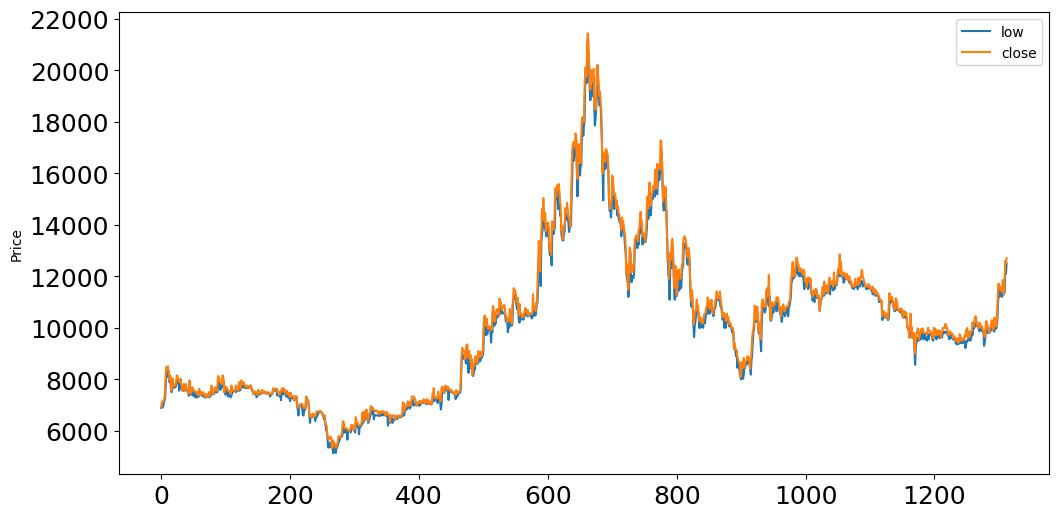

In [13]:
# Draw plot to look the dataset
df.plot(figsize=(12, 6), fontsize=18)
plt.ylabel("Price")
plt.show()

### Low price and close price are correlated => Good for SARIMAX model


In [14]:
# Check if the dataset is stationary or not
from statsmodels.tsa.stattools import adfuller

adfuller(df["close"])

(-1.584523707127448,
 0.4913629480785365,
 12,
 1300,
 {'1%': -3.435390199468821,
  '5%': -2.8637658312426035,
  '10%': -2.567955046745562},
 18249.61406238007)

The high p-value close to 1 suggests that we fail to reject the null hypothesis -> the data is likely non-stationary.


In [15]:
# Agugmented Dickey-Fuller test
def adf_test(dataset, name):
    dftest = adfuller(dataset, autolag="AIC", regression="ct")
    print(f"ADF Test on '{name}' -> p-value: {dftest[1]:.3f}")
    if (
        dftest[0] < dftest[4]["5%"]
        or dftest[0] < dftest[4]["1%"]
        or dftest[0] < dftest[4]["10%"]
    ):
        print("\033[92mReject Ho - Time Series is Stationary\033[0m")
        return True
    else:
        print("\033[91mFailed to Reject Ho - Time Series is Non-Stationary\033[0m")
        return False

In [16]:
# Differencing all features for stationarity until all features are stationary
is_all_stationary = False
diff_order = 0
while not is_all_stationary:
    print("*" * 50 + f" Differencing of order {diff_order} " + "*" * 50)
    train_diff = pd.DataFrame(
        np.diff(train_data, diff_order, axis=0), columns=train_data.columns
    )
    if all([adf_test(train_diff[feature], feature) for feature in train_diff.columns]):
        is_all_stationary = True
        print(f"Dataset is stationary after differencing of order {diff_order}")
        break
    diff_order += 1

************************************************** Differencing of order 0 **************************************************
ADF Test on 'low' -> p-value: 0.848
Failed to Reject Ho - Time Series is Non-Stationary
ADF Test on 'close' -> p-value: 0.843
Failed to Reject Ho - Time Series is Non-Stationary
************************************************** Differencing of order 1 **************************************************
ADF Test on 'low' -> p-value: 0.000
Reject Ho - Time Series is Stationary
ADF Test on 'close' -> p-value: 0.000
Reject Ho - Time Series is Stationary
Dataset is stationary after differencing of order 1


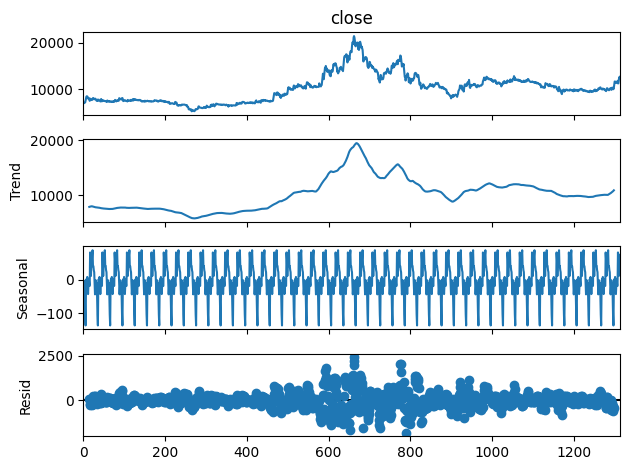

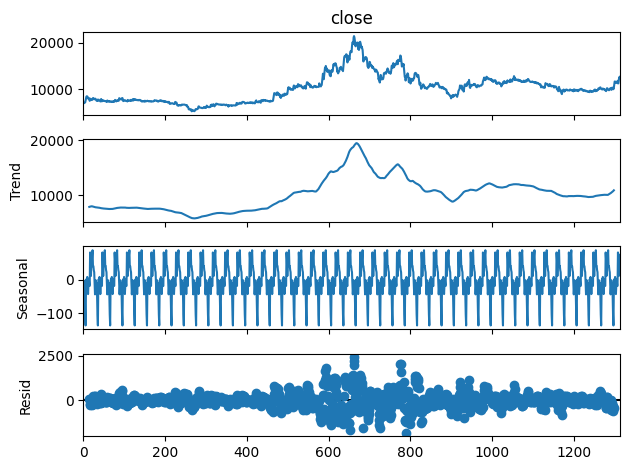

In [17]:
# Decompose the data to see the trend, seasonality and noise
from statsmodels.tsa.seasonal import seasonal_decompose

decompose = seasonal_decompose(df["close"], model="additive", period=30)
decompose.plot()

In [18]:
df1 = df
df_diff = np.diff(train_data["close"], n=1)

In [19]:
# Check again
adfuller(df_diff)

(-9.05389535852299,
 4.7585079585462e-15,
 11,
 906,
 {'1%': -3.4375883271133243,
  '5%': -2.8647353885968214,
  '10%': -2.568471435365895},
 12798.627520578957)

The p-value is 1.04^-15, less than 0.05 -> Dataset is stationary -> Draw ACF to find m


<Figure size 1000x600 with 0 Axes>

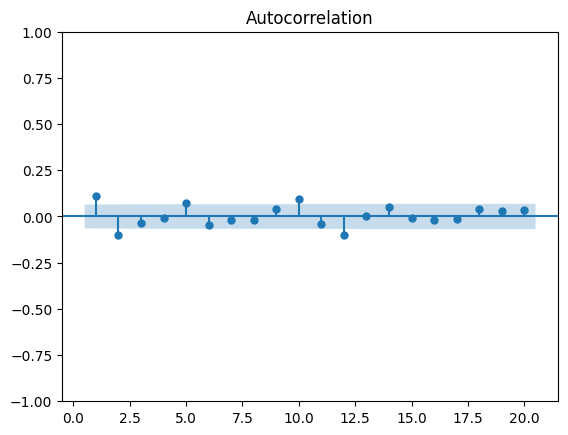

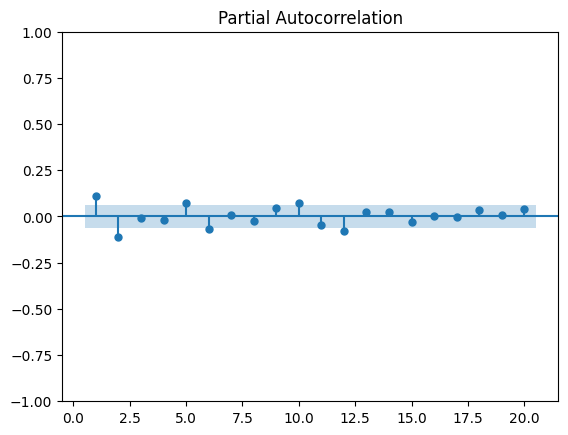

In [20]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(10, 6))
plot_acf(df_diff, lags=20, zero=False)
plot_pacf(df_diff, lags=20, zero=False)
plt.show()

=> m = 5


In [21]:
# Review the dataset again
df

,low,close
0,6900,6900
1,6900,7100
2,6900,7100
3,6940,7170
4,7100,7170
...,...,...
1308,11300,11300
1309,11400,12050
1310,12450,12600
1311,12100,12500


In [22]:
# Use auto_arima to find the best (p, d, q) and (P, D, Q)
from pmdarima.arima import auto_arima

model = auto_arima(
    y_train,
    trace=True,
    d=1,
    max_p=7,
    max_d=7,
    error_action="ignore",
    suppress_warnings=True,
    seasonal=True,
    m=5,
)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[5] intercept   : AIC=13104.732, Time=0.90 sec
 ARIMA(0,1,0)(0,0,0)[5] intercept   : AIC=13127.555, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[5] intercept   : AIC=13113.967, Time=0.03 sec
 ARIMA(0,1,1)(0,0,1)[5] intercept   : AIC=13111.886, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[5]             : AIC=13125.653, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[5] intercept   : AIC=13107.874, Time=0.33 sec
 ARIMA(2,1,2)(1,0,0)[5] intercept   : AIC=13106.736, Time=0.20 sec
 ARIMA(2,1,2)(2,0,1)[5] intercept   : AIC=13100.037, Time=1.08 sec
 ARIMA(2,1,2)(2,0,0)[5] intercept   : AIC=13101.970, Time=0.98 sec
 ARIMA(2,1,2)(2,0,2)[5] intercept   : AIC=13101.252, Time=1.52 sec
 ARIMA(2,1,2)(1,0,2)[5] intercept   : AIC=13101.733, Time=1.15 sec
 ARIMA(1,1,2)(2,0,1)[5] intercept   : AIC=13098.450, Time=1.04 sec
 ARIMA(1,1,2)(1,0,1)[5] intercept   : AIC=13103.904, Time=0.67 sec
 ARIMA(1,1,2)(2,0,0)[5] intercept   : AIC=13101.288, Time=0.48 sec
 ARIMA(1,1,2)(2,0,2

In [23]:
print(model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  919
Model:             SARIMAX(1, 1, 2)x(2, 0, [1], 5)   Log Likelihood               -6541.268
Date:                             Mon, 03 Jun 2024   AIC                          13096.536
Time:                                     21:45:16   BIC                          13130.291
Sample:                                          0   HQIC                         13109.419
                                             - 919                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6703      0.121      5.555      0.000       0.434       0.907
ma.L1         -0.5379      

#### Use SARIMAX to train model


In [24]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Use 'low price' for the exogenous variable
model1 = SARIMAX(
    y_train,
    exog=np.array(train_data["low"]),
    order=(1, 1, 2),
    seasonal_order=(2, 0, 1, 5),
)

model_fit = model1.fit()

c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### Test


In [25]:
exg = np.array(test_data["low"])

y_pred_test = model_fit.predict(
    start=len(y_train), end=len(y_test) + len(y_train) - 1, exog=exg
)

y_pred_test

array([10002.02395989, 10243.9406622 , 10629.23549686, 10956.76009841,
       10523.52428656, 10456.87328674, 10535.71974172, 10795.27954285,
       10057.47494163,  9982.75430341,  9933.57021151,  9724.15622431,
        9273.08350567, 10345.07775983, 10873.99944082, 11061.56362974,
       11037.78590229, 10977.44430903, 10835.17851326, 10958.78962305,
       11138.04521939, 11396.72664108, 11405.89794066, 11497.23394101,
       11097.9265776 , 11479.92992629, 10659.92029627, 10507.80353047,
       10559.36242962, 10774.9461967 , 11086.96825294, 10835.27571173,
       11038.43987354, 11129.76883863, 11240.77212055, 11153.28418903,
       10853.84175896, 11252.8332482 , 10977.78513469, 11142.36885564,
       10954.28319704, 10886.27315123, 10711.84645503, 10660.28658381,
       10454.86175493, 10642.94336905, 11037.57790153, 11018.05741564,
       10885.89979311, 10672.87280179, 10770.57553283, 10978.10525321,
       11038.47490395, 10854.23183967, 10679.39818234, 11061.3965974 ,
      

#### Validate


In [26]:
exg = np.array(val_data["low"])

y_pred_val = model_fit.predict(
    start=len(X_train), end=len(X_train) + len(y_val) - 1, exog=exg
)

y_pred_val

array([ 9981.61100039,  9998.98514824,  9751.4782385 ,  9813.63436659,
        9982.58085989,  9834.27802209,  9780.44024034,  9723.59916927,
        9832.93238717,  9911.30894517,  9749.85357603,  9979.31821802,
        9946.71116906,  9998.05744838,  9914.59034447,  9969.47029666,
        9741.56297424,  9722.04729998,  9926.80181566,  9917.72868871,
        9913.26764958,  9926.99355731,  9742.24174167,  9802.95830278,
        9913.97492679,  9918.33852478,  9894.43431514,  9823.96938733,
       10028.6254827 ,  9835.95005984,  9831.57124389,  9855.45365588,
       10058.61781769, 10047.8819853 , 10015.99455074, 10020.36493696,
       10047.52985884, 10079.08807713, 10079.61491683,  9958.41720482,
        9903.01578295,  9937.07053463,  9742.23087894,  9813.1487647 ,
        9985.3636865 , 10010.14162465,  9792.38737222,  9905.55112306,
        9773.39350054,  9754.28962443,  9780.54699724,  9824.77304164,
        9589.15477968,  9588.62835087,  9556.68541001,  9591.66351363,
      

### Predict the next 30/60/90 days


In [27]:
# Predict next xx days
num_of_days_30 = 30
num_of_days_60 = 60
num_of_days_90 = 90

In [28]:
df

,low,close
0,6900,6900
1,6900,7100
2,6900,7100
3,6940,7170
4,7100,7170
...,...,...
1308,11300,11300
1309,11400,12050
1310,12450,12600
1311,12100,12500


In [29]:
from sklearn.linear_model import LinearRegression

ln_model = LinearRegression()

# Use LM to find the low price the next 30/60/90 days
ln_model.fit(np.array(train_data.index).reshape(-1, 1), train_data["low"])

last_index = df.index[-1]
last_data_30 = pd.RangeIndex(start=last_index, stop=last_index + num_of_days_30, step=1)
last_data_60 = pd.RangeIndex(start=last_index, stop=last_index + num_of_days_60, step=1)
last_data_90 = pd.RangeIndex(start=last_index, stop=last_index + num_of_days_90, step=1)

# Extrapolation variable
exog = np.array(val_data["low"])

# Create an array of 30/60/90 consecutive integers starting from last_index
x_30_days_pred = np.array(
    range(last_index + 1, last_index + num_of_days_30 + 1)
).reshape(-1, 1)

x_60_days_pred = np.array(
    range(last_index + 1, last_index + num_of_days_60 + 1)
).reshape(-1, 1)

x_90_days_pred = np.array(
    range(last_index + 1, last_index + num_of_days_90 + 1)
).reshape(-1, 1)

# Predict the low price - extrapolation variable for the next 30/60/90 days to predict the closeing price
low_30_days_pred = ln_model.predict(x_30_days_pred)
low_60_days_pred = ln_model.predict(x_60_days_pred)
low_90_days_pred = ln_model.predict(x_90_days_pred)

# Predict the closing prices of FPT for the next 30/60/90 days
y_30_days_pred = model_fit.predict(
    start=len(X_train),
    end=len(X_train) + len(x_30_days_pred) - 1,
    exog=low_30_days_pred,
)

y_60_days_pred = model_fit.predict(
    start=len(X_train),
    end=len(X_train) + len(x_60_days_pred) - 1,
    exog=low_60_days_pred,
)

y_90_days_pred = model_fit.predict(
    start=len(X_train),
    end=len(X_train) + len(x_90_days_pred) - 1,
    exog=low_90_days_pred,
)

# Print the predicted closing prices for the next 30 days
print("Predicted closing prices for the next 30 days:")
print(y_30_days_pred)

Predicted closing prices for the next 30 days:
[17232.08051952 17349.95576715 17274.39531544 17334.98774584
 17328.86038572 17311.67808695 17307.30900625 17340.76255522
 17356.67375769 17341.62830026 17341.9129094  17375.89073847
 17351.92647157 17360.8831342  17388.12360982 17400.61394533
 17385.47899993 17425.63850646 17434.90620922 17424.26938459
 17428.45112751 17461.02629704 17438.01445967 17446.13492435
 17473.93601267 17486.94239272 17471.68096513 17511.92361686
 17521.09289932 17510.57041423]


### Plotting the data


In [30]:
def draw_plot(x_next_days, y_next_day, days):
    plt.figure(figsize=(16, 9))
    plt.plot(train_data.index, train_data["close"], label="Train")
    plt.plot(test_data.index, test_data["close"], label="Test")
    plt.plot(val_data.index, val_data["close"], label="Validate")

    plt.plot(test_data.index, y_pred_test, label="Predicted Test", linestyle="--")
    plt.plot(val_data.index, y_pred_val, label="Predicted Validate", linestyle="--")

    plt.plot(
        x_next_days, y_next_day, label=f"Next {days} days", linestyle="--"
    )
    plt.title(f"{stock_name[stock]} Stock Price Forecasting Using SARIMAX")
    plt.legend()
    plt.show()

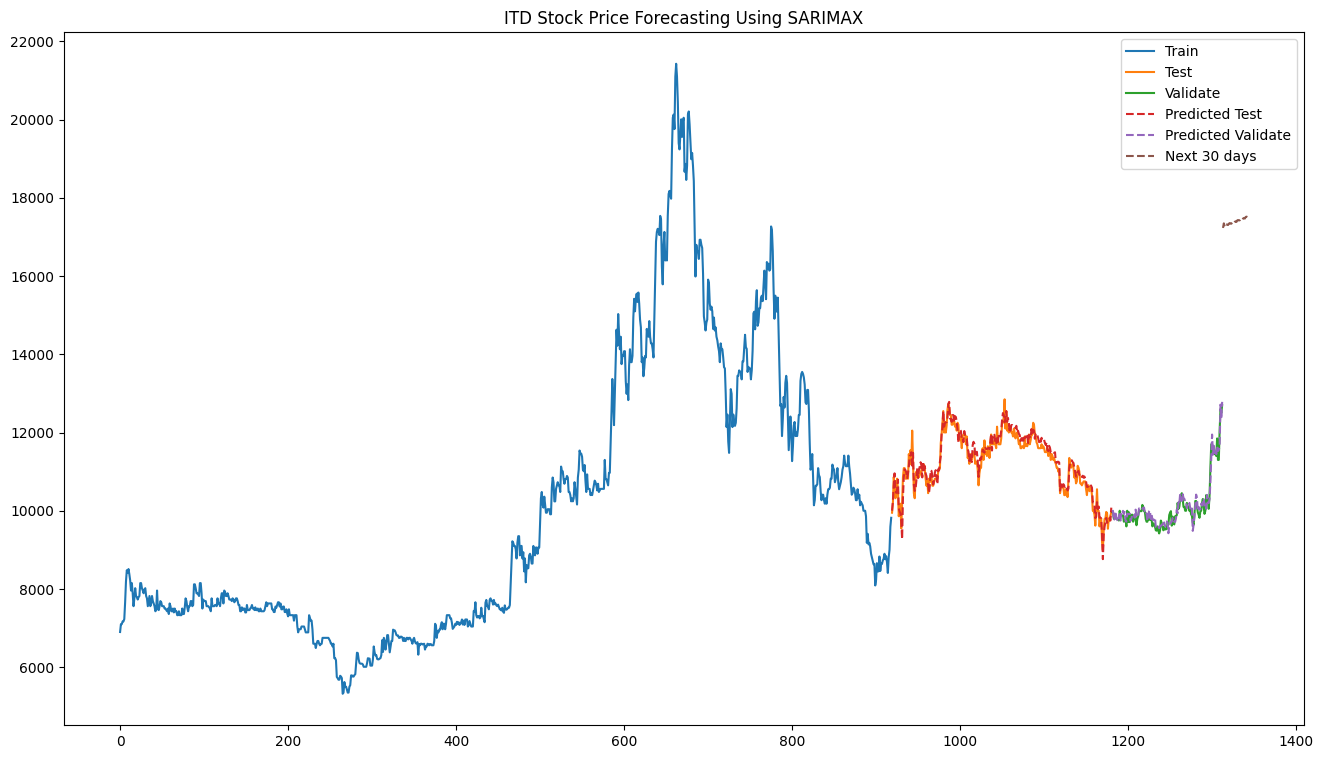

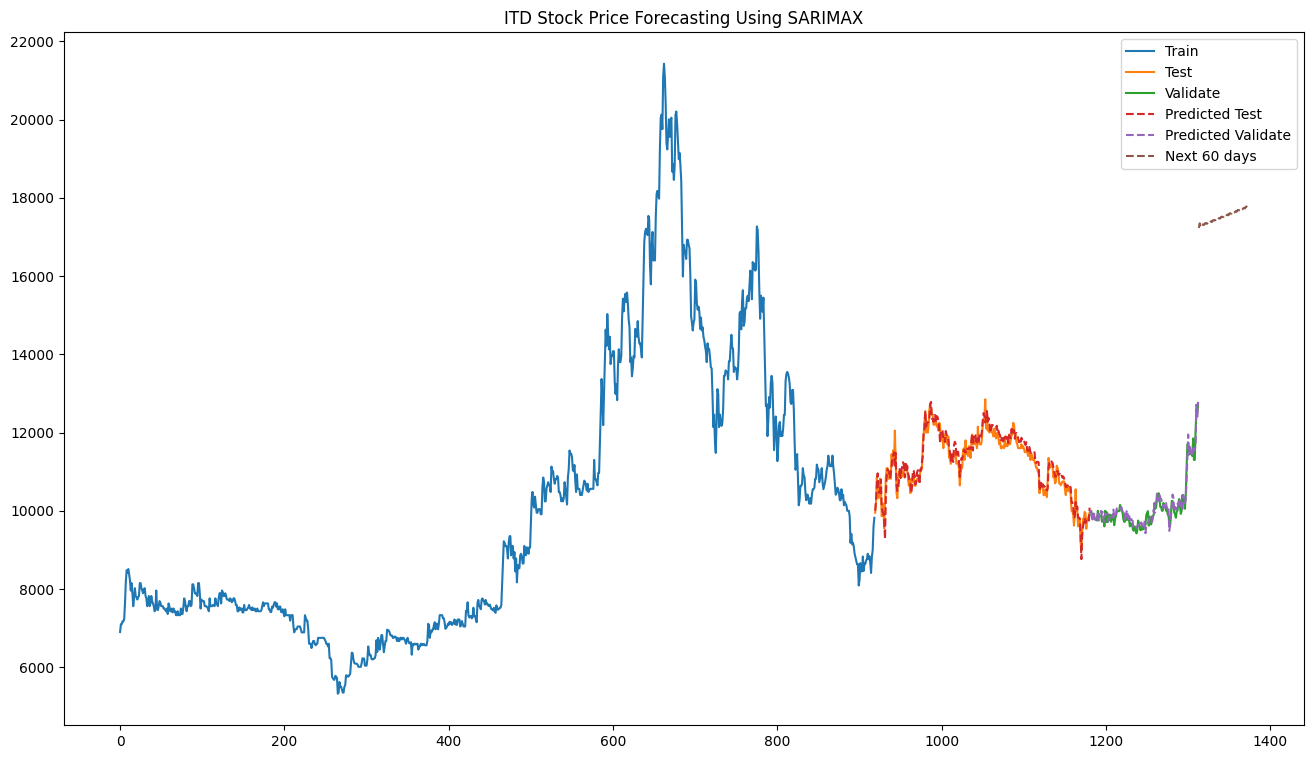

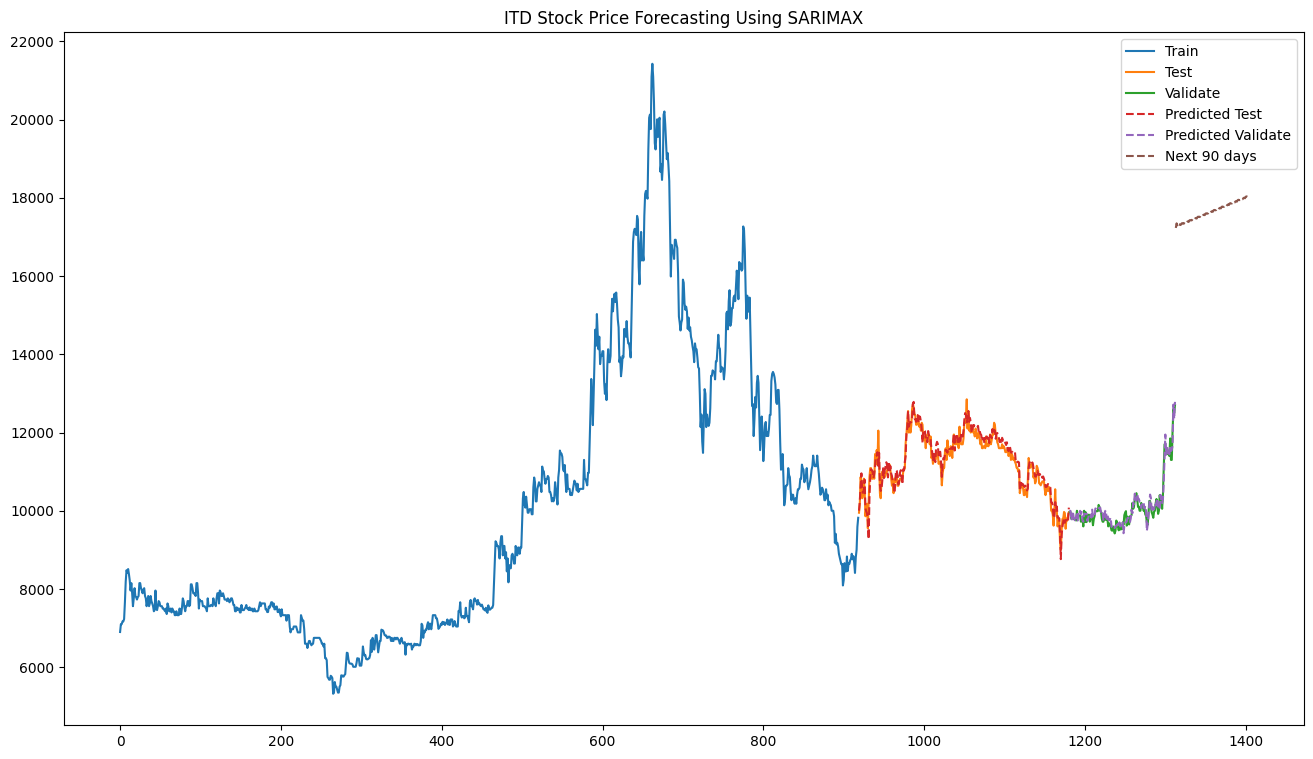

In [31]:
draw_plot(x_30_days_pred, y_30_days_pred, 30)
draw_plot(x_60_days_pred, y_60_days_pred, 60)
draw_plot(x_90_days_pred, y_90_days_pred, 90)

## 3. Model evaluation


In [32]:
# Model evaluation on test set
print(f"RMSE on test data: {rmse(y_test, y_pred_test)}")
print(f"MAE on test data: {mae(y_test, y_pred_test)}")
print(f"MAPE on test data: {mape(y_test, y_pred_test) * 100} %")

RMSE on test data: 201.9246167880842
MAE on test data: 166.67817090707797
MAPE on test data: 1.4911778829662097 %


In [33]:
# Model evaluation on validation set
print(f"RMSE on validation data: {rmse(y_val, y_pred_val)}")
print(f"MAE on validation data: {mae(y_val, y_pred_val)}")
print(f"MAPE on validation data: {mape(y_val, y_pred_val) * 100} %")

RMSE on validation data: 154.6877894033975
MAE on validation data: 129.01585868977733
MAPE on validation data: 1.2737670743491845 %
